# Proyek Akhir : Membuat Model Sistem Rekomendasi Anime
- **Nama:** Putra Faaris Prayoga
- **Email:** putrafaariz47@gmail.com
- **ID Dicoding:** putra_faaris

## Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy.sparse import hstack

# NLTK resource
nltk.download('punkt')
nltk.download('punkt_tab')  # untuk berjaga-jaga, walau ini tidak umum
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading data

In [2]:
df = pd.read_csv("animes.csv")

In [3]:
df.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [4]:
df.describe()

,uid,episodes,members,popularity,ranked,score
count,19311.000000,18605.000000,1.931100e+04,19311.000000,16099.000000,18732.000000
mean,19358.904096,11.460414,3.472609e+04,7720.830304,6866.524194,6.436107
std,14271.446515,47.950386,1.121772e+05,4676.786104,4390.018768,1.007941
min,1.000000,1.000000,2.500000e+01,1.000000,1.000000,1.250000
25%,4833.500000,1.000000,3.880000e+02,3725.000000,2895.500000,5.770000
50%,18327.000000,2.000000,2.389000e+03,7539.000000,6963.000000,6.410000
75%,33896.500000,12.000000,1.450150e+04,11613.000000,10601.500000,7.150000
max,40960.000000,3057.000000,1.871043e+06,16338.000000,14675.000000,9.230000


# EDA


<ipython-input-5-2877919646>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')


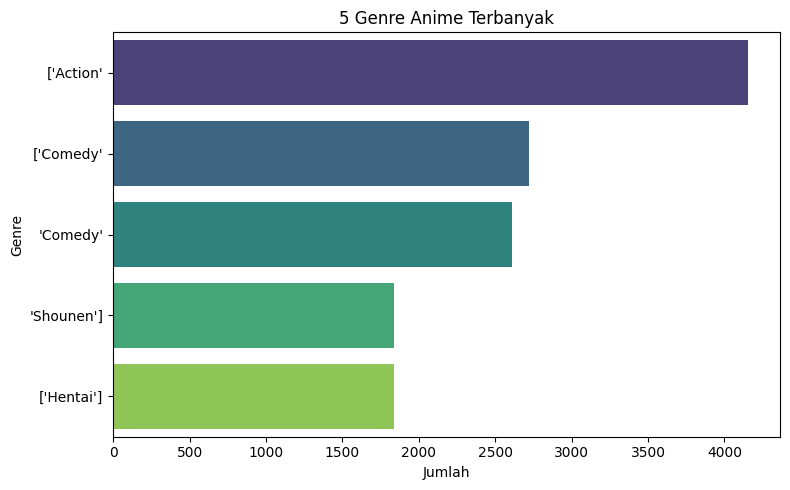

In [5]:
# Menghitung jumlah kemunculan genre
genres = df['genre'].str.split(', ')
all_genres = genres.explode()
genre_counts = all_genres.value_counts()

# Plot 5 genre terbanyak
top_genres = genre_counts.head(5)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('5 Genre Anime Terbanyak')
plt.xlabel('Jumlah')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

In [6]:
# Menghitung jumlah genre unik
total_unique_genres = all_genres.nunique()
print("Jumlah genre unik:", total_unique_genres)

Jumlah genre unik: 162


In [7]:
unique_genres = all_genres.unique()
print("Daftar genre unik:")
print(sorted(unique_genres))

Daftar genre unik:
["'Adventure'", "'Adventure']", "'Cars'", "'Cars']", "'Comedy'", "'Comedy']", "'Dementia'", "'Dementia']", "'Demons'", "'Demons']", "'Drama'", "'Drama']", "'Ecchi'", "'Ecchi']", "'Fantasy'", "'Fantasy']", "'Game'", "'Game']", "'Harem'", "'Harem']", "'Hentai'", "'Hentai']", "'Historical'", "'Historical']", "'Horror'", "'Horror']", "'Josei'", "'Josei']", "'Kids'", "'Kids']", "'Magic'", "'Magic']", "'Martial Arts'", "'Martial Arts']", "'Mecha'", "'Mecha']", "'Military'", "'Military']", "'Music'", "'Music']", "'Mystery'", "'Mystery']", "'Parody'", "'Parody']", "'Police'", "'Police']", "'Psychological'", "'Psychological']", "'Romance'", "'Romance']", "'Samurai'", "'Samurai']", "'School'", "'School']", "'Sci-Fi'", "'Sci-Fi']", "'Seinen'", "'Seinen']", "'Shoujo Ai'", "'Shoujo Ai']", "'Shoujo'", "'Shoujo']", "'Shounen Ai'", "'Shounen Ai']", "'Shounen'", "'Shounen']", "'Slice of Life'", "'Slice of Life']", "'Space'", "'Space']", "'Sports'", "'Sports']", "'Super Power'", "'Sup

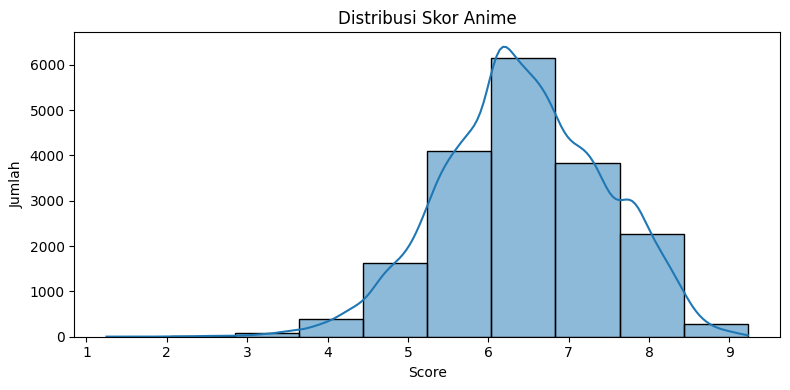

In [8]:
# distribusi skor

plt.figure(figsize=(8, 4))
sns.histplot(df['score'], bins=10, kde=True)
plt.title("Distribusi Skor Anime")
plt.xlabel("Score")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

## Preprocess


In [9]:
# CLEANING DATA

df.drop_duplicates(inplace=True)
df.dropna(subset=['title', 'synopsis', 'genre', 'score', 'ranked'], inplace=True)
df = df[df['score'] > 0]
df = df[df['episodes'] > 0]
df.reset_index(drop=True, inplace=True)

In [10]:
#  TEXT PREPROCESSING (synopsis kata penting saja)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    keywords = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(keywords)

print("Preprocessing synopsis...")
df['clean_synopsis'] = df['synopsis'].apply(preprocess_text)


Preprocessing synopsis...


In [11]:
# FEATURE ENGINEERING

vectorizer = TfidfVectorizer(max_features=3000)
tfidf_matrix = vectorizer.fit_transform(df['clean_synopsis'])

genre_matrix = df['genre'].str.get_dummies(sep=', ')
scaled_features = MinMaxScaler().fit_transform(df[['score', 'ranked']])
final_features = hstack([tfidf_matrix, genre_matrix.values, scaled_features])


In [12]:
# CONTENT-BASED RECOMMENDER FUNCTION

cosine_sim = cosine_similarity(final_features)
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in indices:
        return f"Anime '{title}' tidak ditemukan."
    idx = indices[title]
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    anime_indices = [i[0] for i in sim_scores]
    return df[['title', 'genre', 'score', 'ranked']].iloc[anime_indices]


## Model

In [14]:
# OPTIONAL: RECOMMENDER MODEL (RecommenderNet)

df['anime_id'] = LabelEncoder().fit_transform(df['title'])
x = df[['anime_id']].values
y = df['score'].values

scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

split = int(0.8 * len(df))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_items, embed_size):
        super(RecommenderNet, self).__init__()
        self.item_embedding = layers.Embedding(num_items, embed_size,
                                               embeddings_initializer='he_normal',
                                               embeddings_regularizer=keras.regularizers.l2(1e-4))
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        item_vector = self.item_embedding(inputs[:, 0])
        item_bias = self.item_bias(inputs[:, 0])
        dot_product = tf.reduce_sum(item_vector * item_vector, axis=1, keepdims=True)
        x = tf.nn.sigmoid(dot_product + item_bias)
        return x

num_items = df['anime_id'].nunique()
model = RecommenderNet(num_items=num_items, embed_size=64)
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

print("\nTraining RecommenderNet (Optional)...")
history = model.fit(x_train, y_train, batch_size=16, epochs=50, verbose=1)



Training RecommenderNet (Optional)...
Epoch 1/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6942 - mae: 0.1427
Epoch 2/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6909 - mae: 0.1390
Epoch 3/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6882 - mae: 0.1315
Epoch 4/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.6855 - mae: 0.1272
Epoch 5/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6829 - mae: 0.1216
Epoch 6/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6800 - mae: 0.1193
Epoch 7/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6774 - mae: 0.1148
Epoch 8/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6752 - mae: 0.1096
Epoch 9/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6729 - mae: 0.1051
Epoch 10/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6705 - mae: 0.1021
Epoch 11/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6683 - mae: 0.0976
Epoch 12/50
693/693 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.6663 

## TEST dan Evaluasi

In [16]:
# EVALUASI MODEL

eval_result = model.evaluate(x_test, y_test)
print("Evaluation result (binary_crossentropy, MAE):", eval_result)

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7050 - mae: 0.1293
Evaluation result (binary_crossentropy, MAE): [0.7047159075737, 0.15420563519001007]


In [17]:
# TEST RECOMMENDATION

test_titles = [
    "Fullmetal Alchemist: Brotherhood",
    "Shigatsu wa Kimi no Uso",
    "Made in Abyss",
    "Haikyuu!! Second Season",
    "Steins;Gate"
]

for title in test_titles:
    print(f"\nTop 10 rekomendasi untuk '{title}':")
    print(get_recommendations(title))


Top 10 rekomendasi untuk 'Fullmetal Alchemist: Brotherhood':
                                               title  \
498                              Fullmetal Alchemist   
12029  Fullmetal Alchemist: The Sacred Star of Milos   
3972               Fairy Tail Movie 1: Houou no Miko   
518                                One Piece Film: Z   
502                     One Piece Film: Strong World   
145                                       Fairy Tail   
832                         Fairy Tail: Final Series   
191                                Fairy Tail (2014)   
310                             One Piece Film: Gold   
13617                               Digimon Frontier   

                                                   genre  score  ranked  
498    ['Action', 'Adventure', 'Comedy', 'Drama', 'Fa...   8.25   287.0  
12029  ['Action', 'Adventure', 'Comedy', 'Drama', 'Fa...   7.39  2140.0  
3972   ['Action', 'Adventure', 'Comedy', 'Fantasy', '...   7.56  1535.0  
518    ['Action', 'Advent